In [1]:
import database_functions as func
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import json
import requests
from eda_functions import choropleth
%matplotlib inline

# Create a Database instance
path = r'009_supplemental\cleaned data'
db = func.Database(path)
print("Database initialized successfully.")
# Assuming db is your Database instance

Database initialized successfully.


# Voter's Registration Dataset:

## Task 1: Basic statistics and data overview of the 'voter' table

In [ ]:
voter_df = db.voter()

# Display basic information about the voter table
print(voter_df.info())

# Show summary statistics
print(voter_df.describe())

# Display the first few rows
print(voter_df.head())

# Check for missing values
print(voter_df.isnull().sum())

## Task 2: Visualize party registration percentages

In [ ]:
# Calculate average party registration percentages
party_columns = ['democratic_perc', 'republican_perc', 'no_party_preference_perc']
other_columns = ['american_independent_perc', 'green_perc', 'libertarian_perc', 
                 'peace_and_freedom_perc', 'unknown_perc', 'other_perc']

avg_percentages = voter_df[party_columns].mean()
avg_percentages['other'] = voter_df[other_columns].sum(axis=1).mean()

# Seaborn visualization
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_percentages.index, y=avg_percentages.values)
plt.title('Average Party Registration Percentages')
plt.ylabel('Percentage')
plt.xlabel('Party')
plt.xticks(rotation=45)
plt.show()

def reshape_voter_data_for_party_slider(df, year):
    """
    Reshape voter data for visualization with parties as slider values,
    combining all parties except Democratic and Republican into "Other".
    
    Parameters:
    df (pandas.DataFrame): Original voter dataframe
    year (int): Year to filter the data
    
    Returns:
    pandas.DataFrame: Reshaped dataframe suitable for choropleth with party slider
    """
    # Filter for the specified year
    df_year = df[df['year'] == year].copy()
    
    # Calculate the "Other" category
    other_parties = ['american_independent_perc', 'green_perc', 'libertarian_perc', 
                     'peace_and_freedom_perc', 'other_perc', 'no_party_preference_perc']
    df_year['other_perc'] = df_year[other_parties].sum(axis=1)
    
    # Select only Democratic, Republican, and Other
    parties = ['democratic_perc', 'republican_perc', 'other_perc']
    
    # Melt the dataframe to create a row for each party in each county
    df_melted = pd.melt(df_year, 
                        id_vars=['county_name'], 
                        value_vars=parties,
                        var_name='party', 
                        value_name='percentage')
    
    # Clean up party names
    df_melted['party'] = df_melted['party'].str.replace('_perc', '').str.capitalize()
    
    return df_melted

# Reshape the data
year = 2022  # or whichever year you want to visualize
reshaped_voter_df = reshape_voter_data_for_party_slider(voter_df, year)

# Now use the original choropleth function
party_fig = choropleth(reshaped_voter_df, 
                       hue_column='percentage', 
                       slider_column='party', 
                       title=f"Party Registration Percentages by County ({year})")
party_fig.show()

## Task 3: Analyze registration rates across counties


In [ ]:
# Calculate registration rate
voter_df['registration_rate'] = voter_df['total_registered'] / voter_df['eligible']



# Split top and bottom counties
top_10 = voter_df.groupby('county_name')['registration_rate'].mean().nlargest(10)
bottom_10 = voter_df.groupby('county_name')['registration_rate'].mean().nsmallest(10).sort_values(ascending=False)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.05})

# Plot top 10 counties in the first subplot
sns.barplot(x=top_10.index, y=top_10.values, ax=ax1)
ax1.set_title('Top 10 Counties by Voter Registration Rate')
ax1.set_ylabel('Registration Rate')
ax1.set_xlabel('County')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Plot bottom 10 counties in the second subplot, sorted in descending order
sns.barplot(x=bottom_10.index, y=bottom_10.values, ax=ax2)
ax2.set_title('Bottom 10 Counties by Voter Registration Rate (Descending)')
ax2.set_ylabel('Registration Rate')
ax2.set_ylim(ax1.get_ylim())  # Match the y-axis limits
ax2.set_xlabel('County')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Hide the spines between the subplots to simulate a break
ax2.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Add a break line to suggest discontinuity
d = .015  # How big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-left diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

kwargs.update(transform=ax2.transAxes)  # Switch to the right axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax2.plot((-d, +d), (-d, +d), **kwargs)  # top-right diagonal

plt.show()
choropleth(voter_df, 'registration_rate')

# Census Dataset:

## Task 1: Basic Stastical Analysis

In [ ]:
age_group_columns = ['county_name','under_5_years','age_5_9','age_10_14','age_15_19','age_20_24','age_25_29','age_30_34','age_35_39','age_40_44', 'age_45_49','age_50_54','age_55_59','age_60_64','age_65_69','age_70_74', 'age_75_79', 'age_80_84', 'age_85_plus']

db.census.add_view('age_groups', age_group_columns)
census_age_groups = db.census.age_groups

census_age_groups.head()


In [6]:
melted_df = pd.melt(census_age_groups, id_vars=['county_name'], var_name='age_group', value_name='percentage')
melted_df['percentage'] = melted_df['percentage'].astype(float)
melted_df.head()


def calculate_avg_age(df):
    """
    Calculate the estimated average age for each county using a weighted average.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    age_groups = {
        'under_5_years': 2.5,
        'age_5_9': 7,
        'age_10_14': 12,
        'age_15_19': 17,
        'age_20_24': 22,
        'age_25_29': 27,
        'age_30_34': 32,
        'age_35_39': 37,
        'age_40_44': 42,
        'age_45_49': 47,
        'age_50_54': 52,
        'age_55_59': 57,
        'age_60_64': 62,
        'age_65_69': 67,
        'age_70_74': 72,
        'age_75_79': 77,
        'age_80_84': 82,
        'age_85_plus': 90
    }
    
    weighted_columns = []
    for group, age in age_groups.items():
        weighted_column = f'{group}_weighted'
        df_copy.loc[:, weighted_column] = df_copy[group] * age
        weighted_columns.append(weighted_column)
    
    df_copy.loc[:, 'estimated_avg_age'] = df_copy[weighted_columns].sum(axis=1) / 100
    return df_copy

def create_stacked_bar_plot(df):
    """
    Create a stacked bar plot showing top 10 and bottom 10 counties based on estimated average age.
    """
    # Sort counties by estimated average age
    sorted_counties = df.sort_values('estimated_avg_age', ascending=False)
    
    # Get top 10 and bottom 10 counties
    top_10 = sorted_counties.head(10)
    bottom_10 = sorted_counties.tail(10)[::-1]  # Reverse to show in descending order
    
    # Combine top and bottom counties
    plot_data = pd.concat([top_10, bottom_10])
    
    # Create subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Top 10 Counties by Avg Age', 'Bottom 10 Counties by Avg Age'))
    
    # Define age groups for stacking
    age_groups = ['under_5_years', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 
                  'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 
                  'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 
                  'age_75_79', 'age_80_84', 'age_85_plus']
    
    # Color scale for age groups
    colors = px.colors.sequential.Viridis[::-1]  # Reverse Viridis color scale
    
    # Add bars for each age group
    for i, age_group in enumerate(age_groups):
        fig.add_trace(
            go.Bar(
                x=plot_data['county_name'][:10],
                y=plot_data[age_group][:10],
                name=age_group,
                marker_color=colors[i % len(colors)]
            ),
            row=1, col=1
        )
        fig.add_trace(
            go.Bar(
                x=plot_data['county_name'][10:],
                y=plot_data[age_group][10:],
                name=age_group,
                marker_color=colors[i % len(colors)],
                showlegend=False
            ),
            row=1, col=2
        )
    
    # Update layout
    fig.update_layout(
        barmode='stack',
        title='Age Distribution in California Counties',
        height=600,
        width=1200
    )
    
    # Update x-axis
    fig.update_xaxes(title_text="County", tickangle=45, row=1, col=1)
    fig.update_xaxes(title_text="County", tickangle=45, row=1, col=2)
    
    # Update y-axis
    fig.update_yaxes(title_text="Percentage", row=1, col=1)
    fig.update_yaxes(title_text="Percentage", row=1, col=2)
    
    return fig


In [ ]:
fig = choropleth(melted_df, 'percentage', 'age_group', 'Age Groups by County in California')
fig.show()

df = calculate_avg_age(census_age_groups)
fig = create_stacked_bar_plot(df)
fig.show()

In [ ]:
def create_full_age_distribution_heatmap(df):
    """
    Create a heatmap showing age distribution for all California counties.
    """
    # Sort counties by estimated average age
    sorted_counties = df.sort_values('estimated_avg_age', ascending=False)
    
    # Define age groups
    age_groups = ['under_5_years', 'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 
                  'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49', 
                  'age_50_54', 'age_55_59', 'age_60_64', 'age_65_69', 'age_70_74', 
                  'age_75_79', 'age_80_84', 'age_85_plus']
    
    # Prepare data for heatmap
    heatmap_data = sorted_counties[age_groups]
    
    # Create heatmap
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_data.values,
        y=sorted_counties['county_name'],
        x=age_groups,
        colorscale='Viridis',
        colorbar=dict(title='Percentage'),
    ))
    
    # Update layout
    fig.update_layout(
        title='Age Distribution in All California Counties (Sorted by Average Age)',
        yaxis_title='County',
        xaxis_title='Age Group',
        xaxis_tickangle=-45,
        height=1500,  # Increased height to accommodate all counties
        width=1000,
    )
    
    # Add annotations for average age
    for i, county in enumerate(sorted_counties['county_name']):
        fig.add_annotation(
            y=county,
            x='age_85_plus',
            text=f"{sorted_counties['estimated_avg_age'].iloc[i]:.1f}",
            showarrow=False,
            xshift=50,
            font=dict(size=8)
        )
    
    return fig

# Usage:
df = calculate_avg_age(census_age_groups)
fig = create_full_age_distribution_heatmap(df)
fig.show()

In [ ]:
db.tables.keys()

In [ ]:
db.ballot().head()

# Fascility

## Task 1: Basic statistics and data overview of the 'fascility' table

In [ ]:
db.tables.keys()

In [2]:
# Load the fascility_records table
fascility_records_df = db.fascility_records()
# remove '_1' from the column names, '_1' was added to the column names to avoid conflicts with the column names from aggregated fasciltiy table
fascility_records_df.columns = [col.replace('_1', '') for col in fascility_records_df.columns]

# display basic information about the fascility table
print(fascility_records_df.info())

# show summary statistics
print(fascility_records_df.describe())

# check for missing values
print(fascility_records_df.isnull().sum())

# display the first few rows
fascility_records_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37741 entries, 0 to 37740
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          37738 non-null  float64
 1   cnn           37741 non-null  int64  
 2   fac_name      37741 non-null  object 
 3   county_name   36941 non-null  object 
 4   stations      37741 non-null  int64  
 5   prof_np       37741 non-null  object 
 6   chain_own     37741 non-null  object 
 7   chain_org     37735 non-null  object 
 8   survey_count  23504 non-null  float64
 9   survey_rate   6564 non-null   float64
 10  fac_star      23504 non-null  float64
 11  xp_star       6564 non-null   float64
 12  comm_scr      23504 non-null  float64
 13  quality_scr   23504 non-null  float64
 14  info_scr      23504 non-null  float64
 15  phys_scr      23504 non-null  float64
 16  staff_scr     23504 non-null  float64
 17  fac_scr       23504 non-null  float64
dtypes: float64(11), int64(2), 

year    cnn                              fac_name  county_name  stations  \
0  2024.0  52305  SANTA CLARA VALLEY RENAL CARE CENTER  Santa Clara        25   
1  2023.0  52305  SANTA CLARA VALLEY RENAL CARE CENTER  Santa Clara        25   
2  2022.0  52305  SANTA CLARA VALLEY RENAL CARE CENTER  Santa Clara        25   
3  2021.0  52305  SANTA CLARA VALLEY RENAL CARE CENTER  Santa Clara        25   
4  2020.0  52305  SANTA CLARA VALLEY RENAL CARE CENTER  Santa Clara        25   

      prof_np chain_own    chain_org  survey_count  survey_rate  fac_star  \
0  non_profit        no  Independent          47.0         19.0       3.0   
1  non_profit        no  Independent          52.0         22.0       4.0   
2  non_profit        no  Independent          46.0          NaN       4.0   
3  non_profit        no  Independent          39.0          NaN       5.0   
4  non_profit        no  Independent          39.0          NaN       5.0   

   xp_star  comm_scr  quality_scr  info_scr  phys_scr  staff_scr  fac_scr  
0      4.0      85.0         85.0      81.0      88.0       88.0     89.0  
1      4.0      79.0         82.0      79.0      87.0       88.0     89.0  
2      NaN      92.0         84.0      82.0      93.0       90.0     90.0  
3      NaN      88.0         85.0      91.0      93.0       95.0     96.0  
4      NaN      88.0         85.0      91.0      93.0       95.0     96.0

Missing value counts:
year                3
cnn                 0
fac_name            0
county_name       800
stations            0
prof_np             0
chain_own           0
chain_org           6
survey_count    14237
survey_rate     31177
fac_star        14237
xp_star         31177
comm_scr        14237
quality_scr     14237
info_scr        14237
phys_scr        14237
staff_scr       14237
fac_scr         14237
dtype: int64


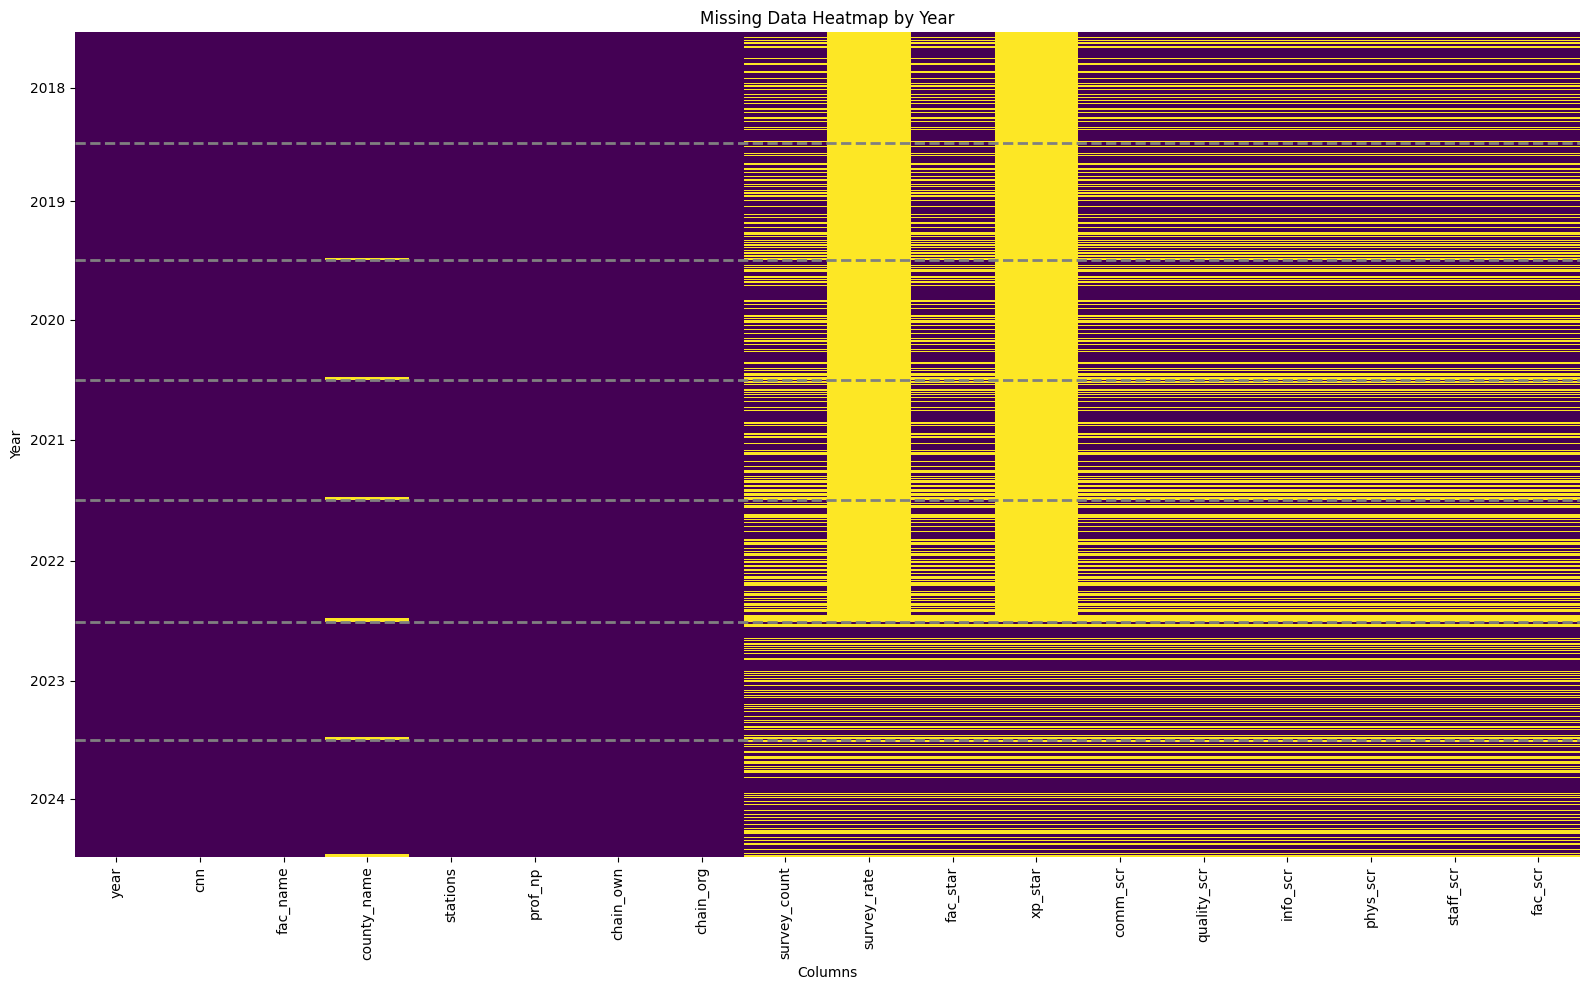

In [13]:

# Sort the dataframe by year and county_name
fascility_records_df = fascility_records_df.sort_values(['year', 'county_name']).reset_index(drop=True)

# Count missing values in each column
missing_counts = fascility_records_df.isnull().sum()
print("Missing value counts:")
print(missing_counts)

# Create the heatmap
plt.figure(figsize=(16, 10))
ax = sns.heatmap(fascility_records_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)

# Add horizontal lines to separate years
years = fascility_records_df['year'].dropna().unique()
year_indices = [fascility_records_df[fascility_records_df['year'] == year].index[0] for year in years]

for idx in year_indices[1:]:  # Start from the second year
    plt.axhline(y=idx, color='gray', linestyle='--', linewidth=2)

# Set y-axis ticks and labels
ax.set_yticks([idx + (year_indices[i+1] - idx)/2 if i+1 < len(year_indices) else idx + (len(fascility_records_df) - idx)/2 
               for i, idx in enumerate(year_indices)])
ax.set_yticklabels([int(year) for year in years], rotation=0)  # Convert years to integers

plt.title('Missing Data Heatmap by Year')
plt.xlabel('Columns')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

Text(0.5, 1.02, 'Pairwise Relationships of Facility Metrics by Chain Ownership')

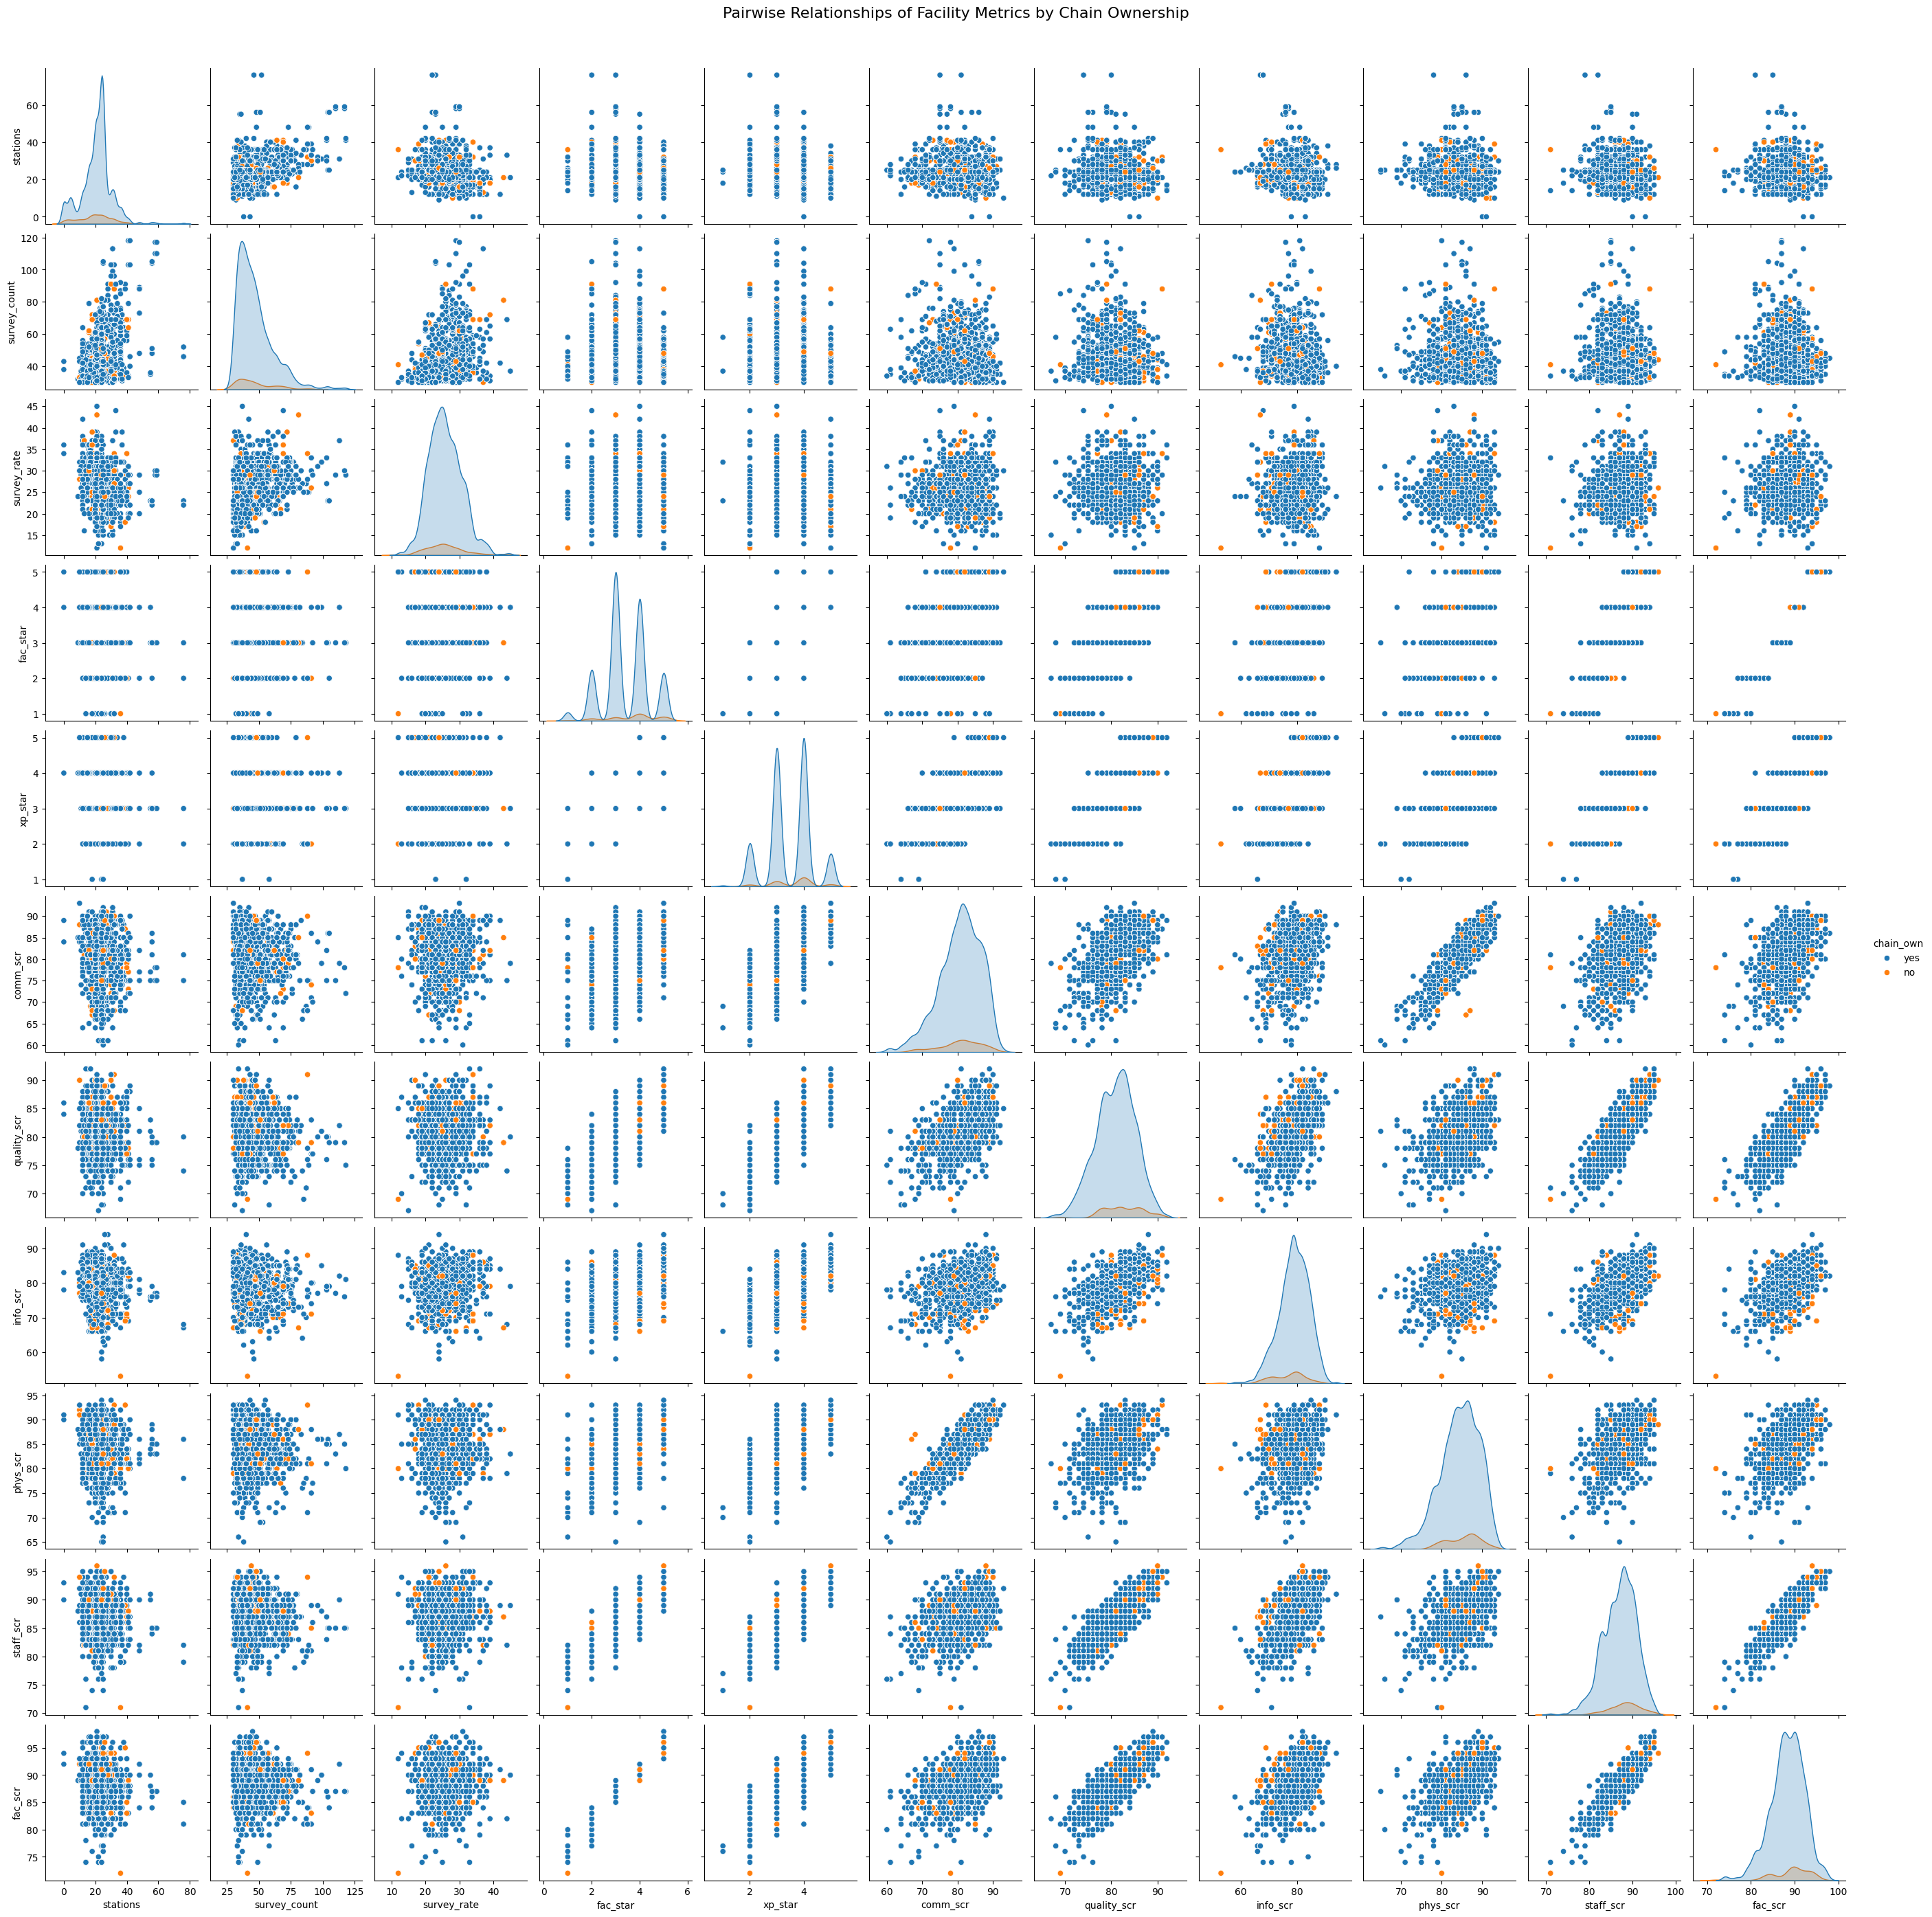

In [17]:
# constrain fascility_records_df to rows where year is 2023 or 2024:
fascility_records_df_2023_2024 = fascility_records_df[fascility_records_df['year'].isin([2023, 2024])]

columns = ['stations',
 'survey_count',
 'survey_rate',
 'fac_star',
 'xp_star',
 'comm_scr',
 'quality_scr',
 'info_scr',
 'phys_scr',
 'staff_scr',
 'fac_scr']
# Create the pairplot with the filtered columns
g = sns.pairplot(data=fascility_records_df_2023_2024, vars=columns, hue='chain_own')

# Add a title to the entire pairplot
g.fig.suptitle("Pairwise Relationships of Facility Metrics by Chain Ownership", 
               fontsize=16, y=1.02)


Text(0.5, 1.02, 'Pairwise Relationships of Facility Metrics by Profit/Non-Profit Ownership')

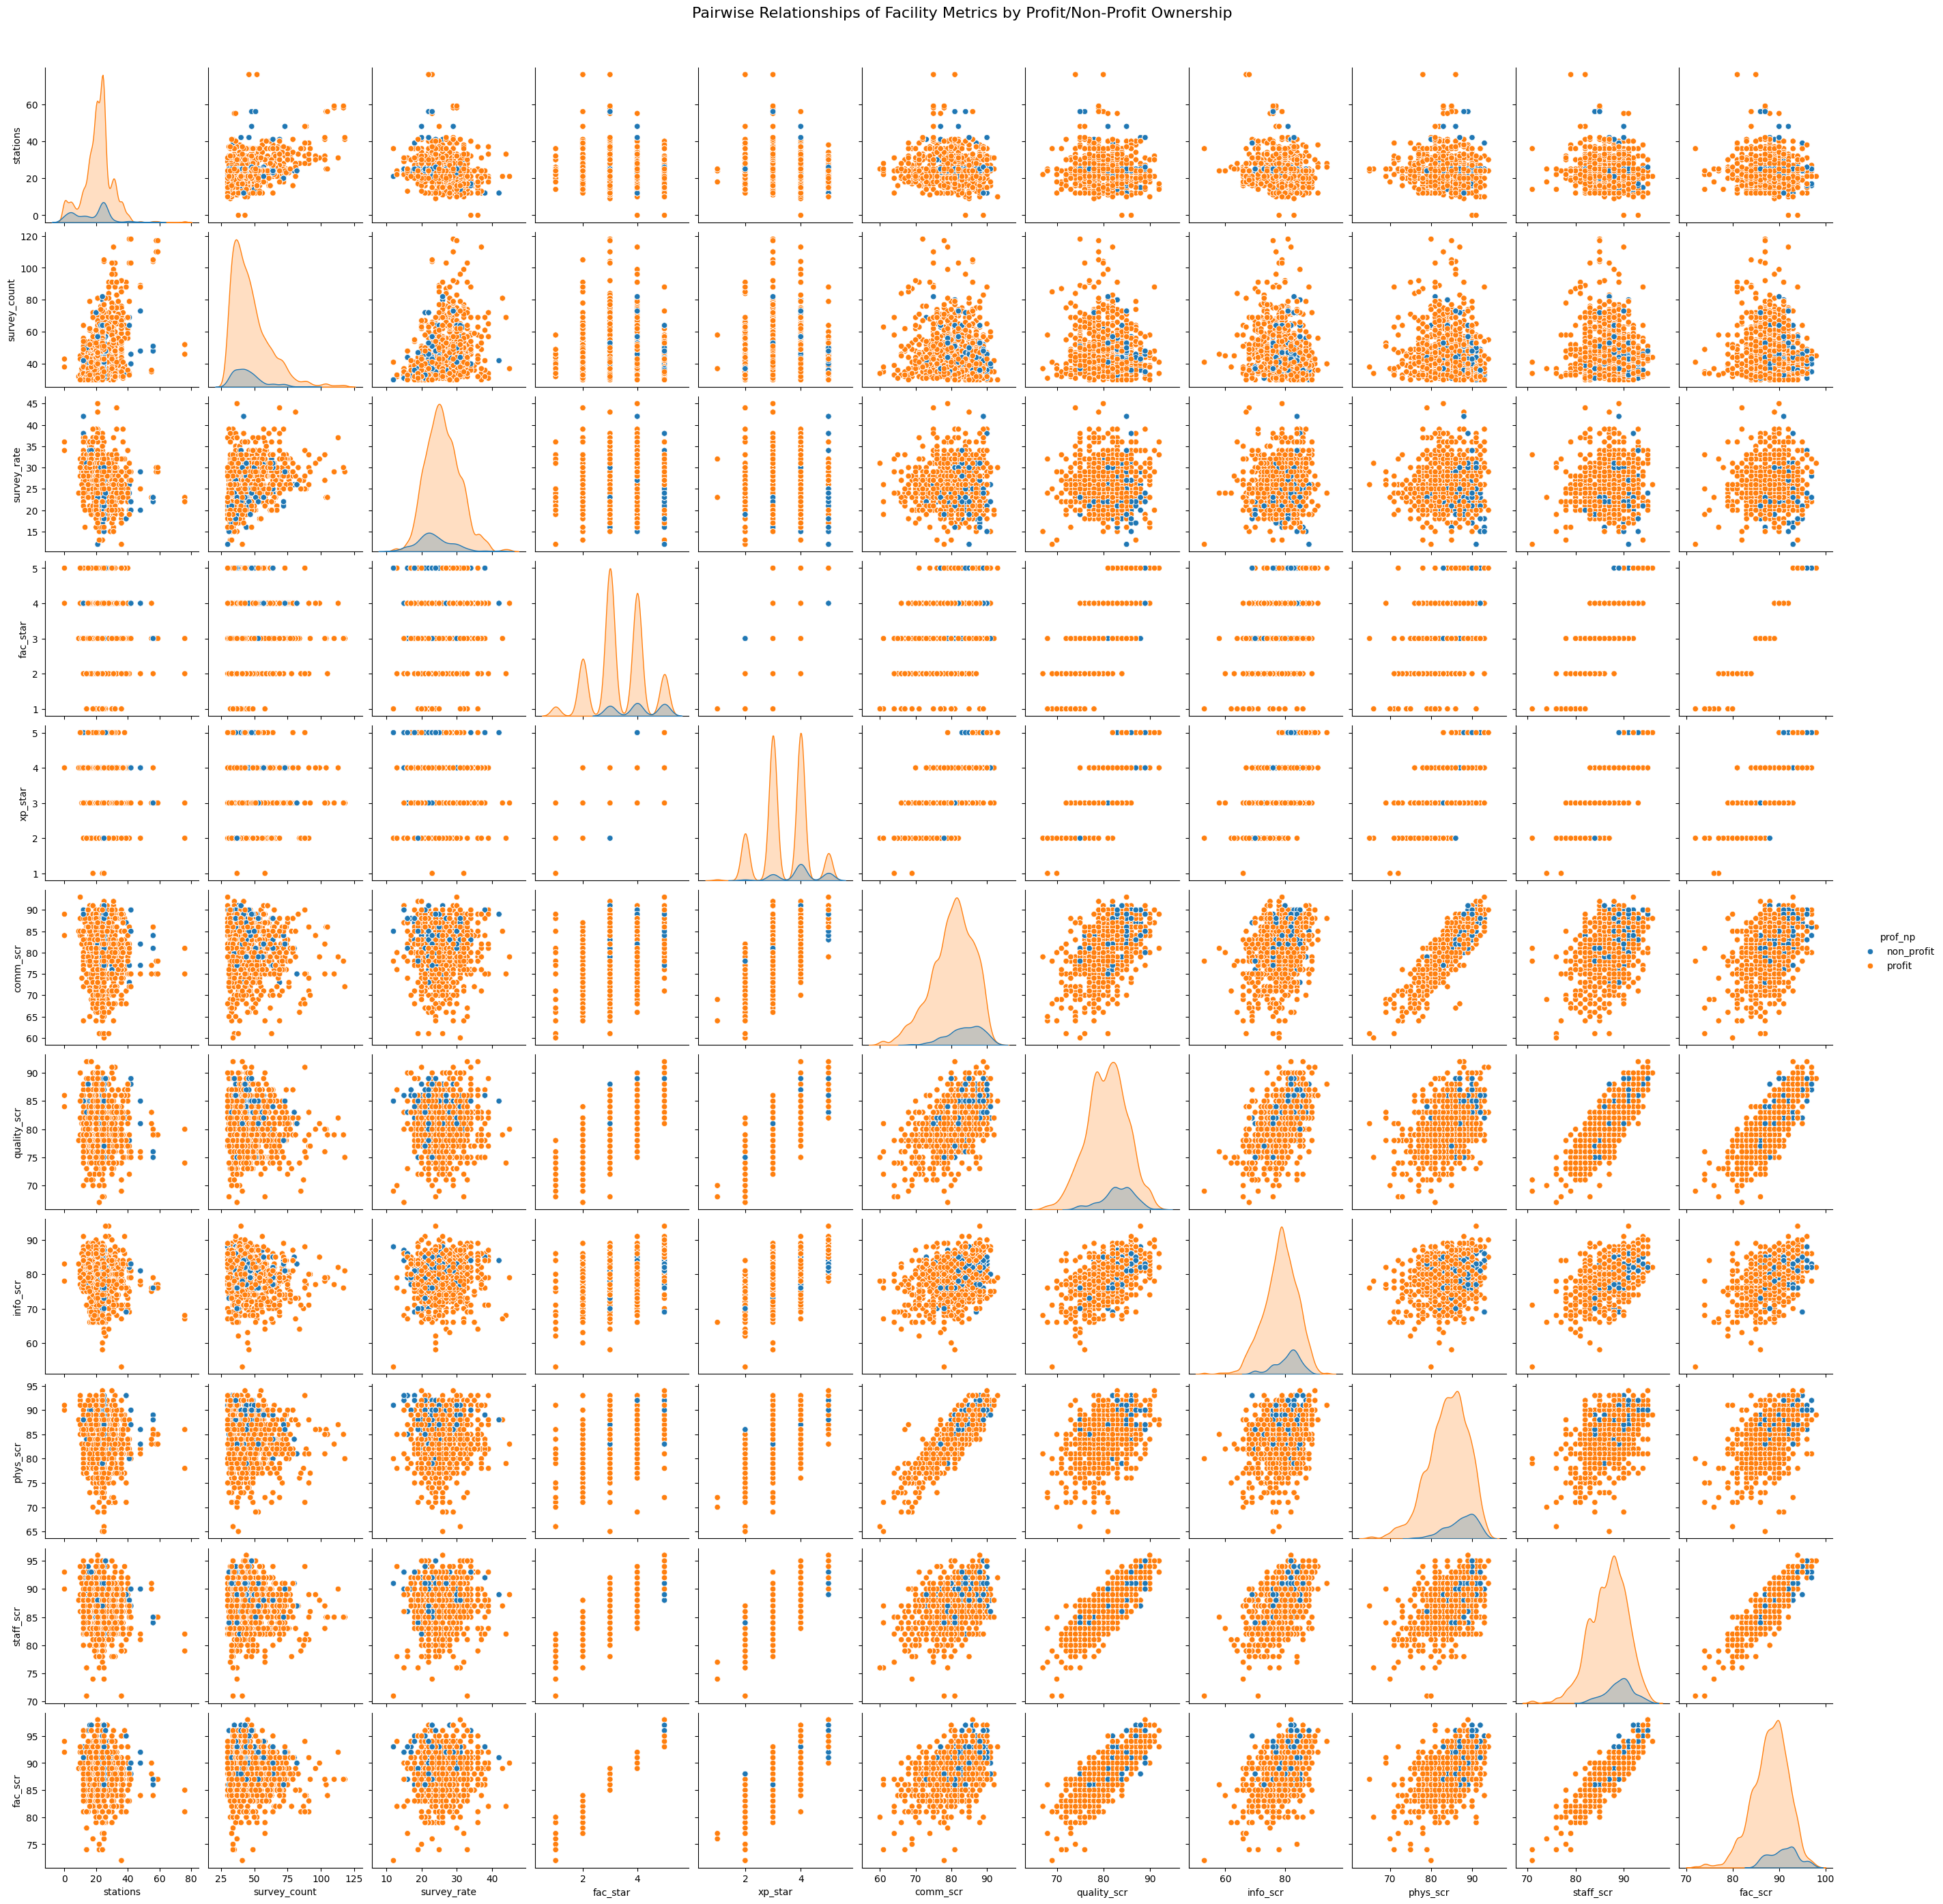

In [18]:
# constrain fascility_records_df to rows where year is 2023 or 2024:
fascility_records_df_2023_2024 = fascility_records_df[fascility_records_df['year'].isin([2023, 2024])]

columns = ['stations',
 'survey_count',
 'survey_rate',
 'fac_star',
 'xp_star',
 'comm_scr',
 'quality_scr',
 'info_scr',
 'phys_scr',
 'staff_scr',
 'fac_scr']
# Create the pairplot with the filtered columns
g = sns.pairplot(data=fascility_records_df_2023_2024, vars = columns, hue='prof_np')

# Add a title to the entire pairplot
g.fig.suptitle("Pairwise Relationships of Facility Metrics by Profit/Non-Profit Ownership", 
               fontsize=16, y=1.02)
